https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, SimpleRNN, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

In [2]:
import tensorflow as tf
import keras as keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.13.0
Keras version: 2.13.1


In [3]:
dataframe = pd.read_csv("data/raw/DAX_Data.csv", usecols=[1])
dataframe = dataframe.dropna()
#plt.plot(dataframe)
dataframe.shape

(9213, 1)

In [4]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape
# Datentypen ändern von int64 zu float32
# sobald die values sind die bereits float 64 

(9213, 1)

In [5]:
print(dataset.shape)
dataset

(9213, 1)


array([[ 1005.19],
       [  956.49],
       [  996.1 ],
       ...,
       [18406.06],
       [18576.58],
       [18649.08]], dtype=float32)

In [6]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)
dataset.shape

# Daten umarrangerien damit sie eine Saklierung haben von 0 bis 1. Wobei 1 = max und 0 = min
#scaler.fit = transformiert erst die daten die zeile davor

(9213, 1)

In [7]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# daten aufteilen in train und test
# validation data kommt er später

In [8]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


# Dieser Prozess hilft dem RNN-Modell, zeitliche Abhängigkeiten 
# und Muster im Datensatz zu lernen, indem es auf frühere Werte in 
# den Sequenzen zurückgreift, um zukünftige Werte vorherzusagen.

In [9]:
seq_size = 5  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (6074, 5)
Shape of test set: (3127, 5)


In [10]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Optimizer mit spezifischer Lernrate
#optimizer = Adam(learning_rate=0.1)

# Modell kompilieren mit geeigneten Metriken
model.compile(loss='mean_squared_error', optimizer='adam')


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 64)          17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=2, epochs=10)

Epoch 1/10
190/190 - 2s - loss: 0.0048 - val_loss: 0.0156 - 2s/epoch - 9ms/step
Epoch 2/10
190/190 - 0s - loss: 6.1022e-05 - val_loss: 0.0051 - 234ms/epoch - 1ms/step
Epoch 3/10
190/190 - 0s - loss: 4.0228e-05 - val_loss: 8.1112e-04 - 234ms/epoch - 1ms/step
Epoch 4/10
190/190 - 0s - loss: 3.1432e-05 - val_loss: 1.3780e-04 - 232ms/epoch - 1ms/step
Epoch 5/10
190/190 - 0s - loss: 2.8876e-05 - val_loss: 2.9327e-04 - 232ms/epoch - 1ms/step
Epoch 6/10
190/190 - 0s - loss: 2.8339e-05 - val_loss: 3.2154e-04 - 230ms/epoch - 1ms/step
Epoch 7/10
190/190 - 0s - loss: 2.7864e-05 - val_loss: 3.7393e-04 - 233ms/epoch - 1ms/step
Epoch 8/10
190/190 - 0s - loss: 2.7913e-05 - val_loss: 3.7756e-04 - 229ms/epoch - 1ms/step
Epoch 9/10
190/190 - 0s - loss: 2.7247e-05 - val_loss: 5.2814e-04 - 230ms/epoch - 1ms/step
Epoch 10/10
190/190 - 0s - loss: 2.7444e-05 - val_loss: 3.6632e-04 - 231ms/epoch - 1ms/step


In [16]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(6074, 1, 5) (6074,) (3127, 1, 5) (3127,)


In [11]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

98/98 [==============================] - 0s 366us/step


((6074, 1), (3127, 1))

In [12]:
trainX.shape, trainY.shape, testX.shape, testY.shape


((6074, 1, 5), (6074,), (3127, 1, 5), (3127,))

In [13]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

NameError: name 'scaler' is not defined

In [14]:
print(trainPredict.shape, trainY.shape)
testPredict.shape, testY.shape

(6074, 1) (6074,)


((3127, 1), (3127,))

In [15]:
trainPredict[:,0].shape, trainPredict.shape


((6074,), (6074, 1))

In [16]:
trainPredict[:,0]

array([2792.5906, 2792.5906, 2792.5906, ..., 2792.5906, 2792.5906,
       2792.5906], dtype=float32)

In [ ]:
# Anzahl der zukünftigen Tage, die vorhergesagt werden sollen
future_days = 10

# Liste zur Speicherung der zukünftigen Vorhersagen
futurePredict = []

# Nehmen Sie die letzten bekannten Daten aus dem Datensatz
last_known_data = testX[-1]  # Das letzte bekannte Fenster von Daten

# Schleife, um die zukünftigen Werte zu generieren
for _ in range(future_days):
    # Machen Sie eine Vorhersage für den nächsten Tag
    next_pred = model.predict(last_known_data.reshape(1, seq_size, 1))
    
    # Speichern Sie die Vorhersage
    futurePredict.append(next_pred[0, 0])
    
    # Fügen Sie die Vorhersage an das Ende der Eingabedaten und entfernen Sie das erste Element
    last_known_data = np.append(last_known_data[1:], next_pred)

# Rücktransformation der zukünftigen Vorhersagen zu den ursprünglichen Werten
futurePredict = np.array(futurePredict).reshape(-1, 1)
futurePredict = scaler.inverse_transform(futurePredict)

# Anzeigen der zukünftigen Vorhersagen
print(f"Future predictions for the next {future_days} days:")
for i, pred in enumerate(futurePredict):
    print(f"Day {i+1}: {pred[0]}")


In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

InvalidParameterError: The 'y_true' parameter of mean_squared_error must be an array-like. Got 1026.69 instead.

In [18]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

In [19]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

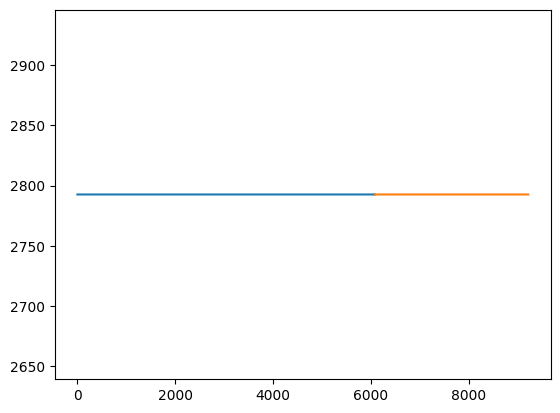

In [20]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

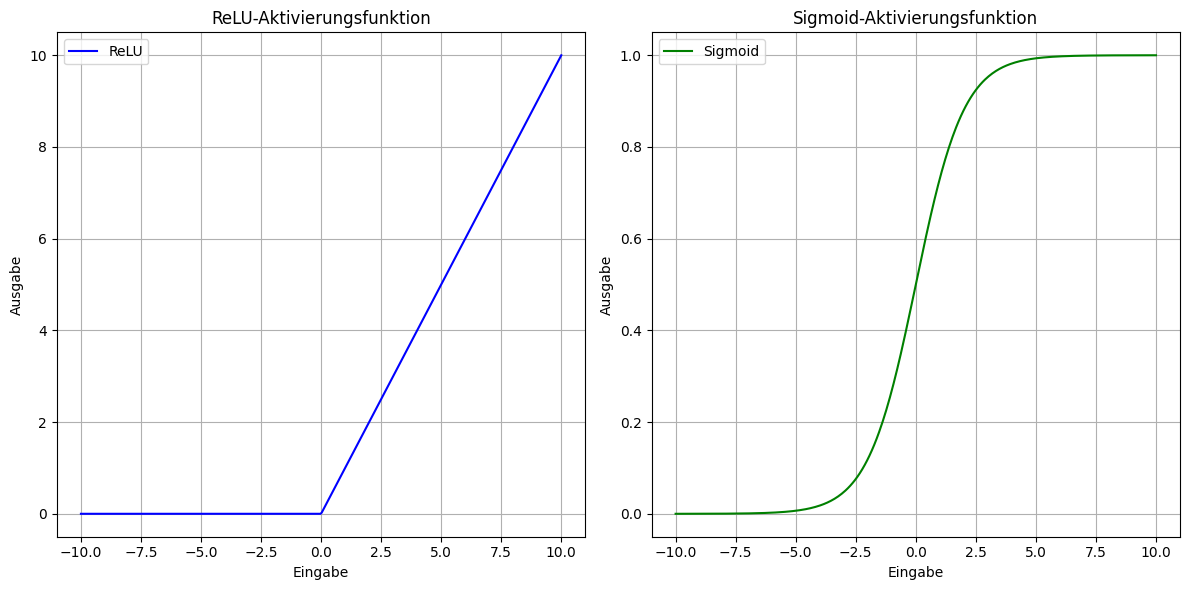

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ReLU-Aktivierungsfunktion
def relu(x):
    return np.maximum(0, x)

# Sigmoid-Aktivierungsfunktion
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Eingabebereich
x = np.linspace(-10, 10, 400)

# Berechnung der Ausgaben
y_relu = relu(x)
y_sigmoid = sigmoid(x)

# Erstellung der Grafiken
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ReLU-Grafik
ax1.plot(x, y_relu, label='ReLU', color='blue')
ax1.set_title('ReLU-Aktivierungsfunktion')
ax1.set_xlabel('Eingabe')
ax1.set_ylabel('Ausgabe')
ax1.legend()
ax1.grid(True)

# Sigmoid-Grafik
ax2.plot(x, y_sigmoid, label='Sigmoid', color='green')
ax2.set_title('Sigmoid-Aktivierungsfunktion')
ax2.set_xlabel('Eingabe')
ax2.set_ylabel('Ausgabe')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#save as png
fig.savefig('activation_functions.png')


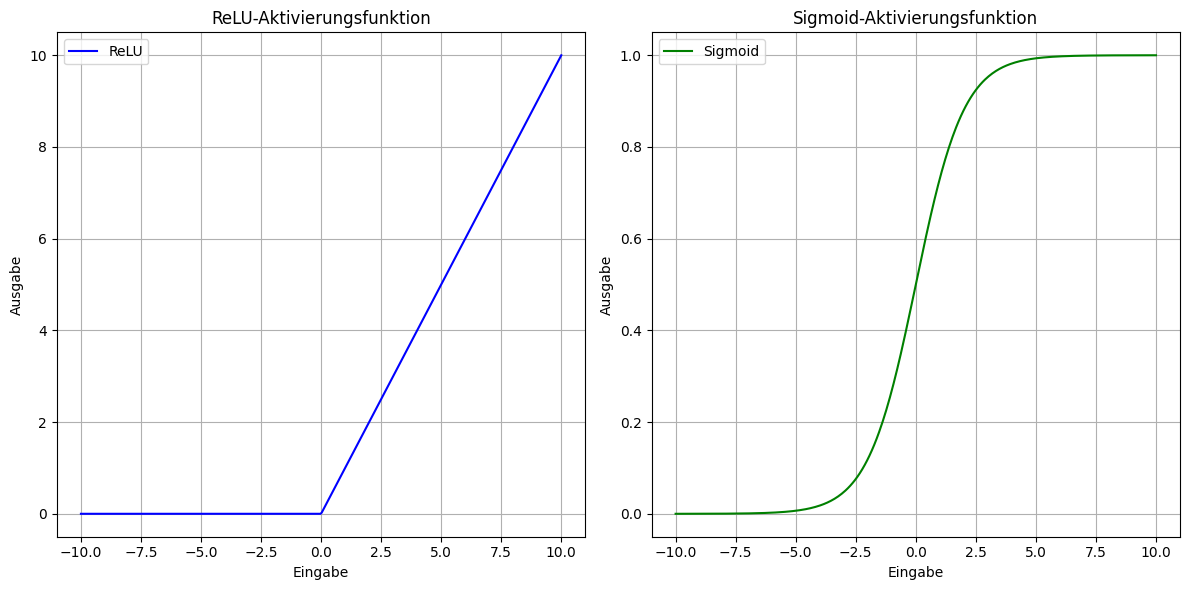

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ReLU-Aktivierungsfunktion
def relu(x):
    return np.maximum(0, x)

# Sigmoid-Aktivierungsfunktion
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Eingabebereich
x = np.linspace(-10, 10, 400)

# Berechnung der Ausgaben
y_relu = relu(x)
y_sigmoid = sigmoid(x)

# Erstellung der Grafiken
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ReLU-Grafik
ax1.plot(x, y_relu, label='ReLU', color='blue')
ax1.set_title('ReLU-Aktivierungsfunktion')
ax1.set_xlabel('Eingabe')
ax1.set_ylabel('Ausgabe')
ax1.legend()
ax1.grid(True)

# Sigmoid-Grafik
ax2.plot(x, y_sigmoid, label='Sigmoid', color='green')
ax2.set_title('Sigmoid-Aktivierungsfunktion')
ax2.set_xlabel('Eingabe')
ax2.set_ylabel('Ausgabe')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


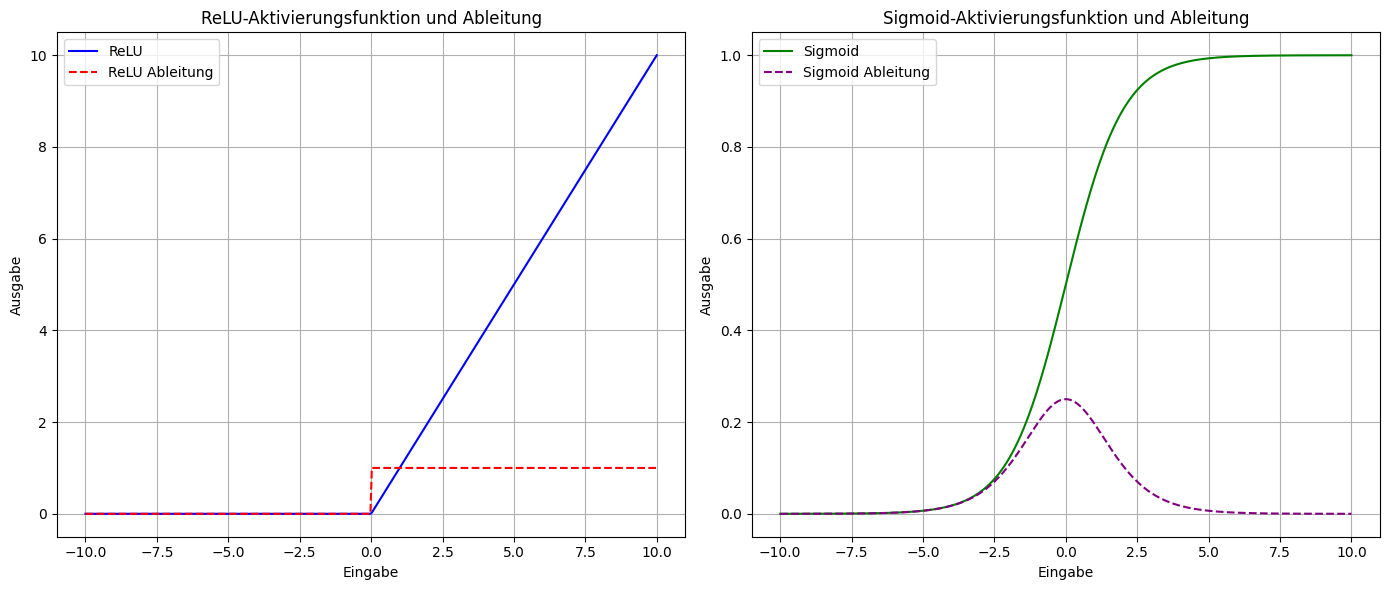

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ReLU-Aktivierungsfunktion und ihre Ableitung
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Sigmoid-Aktivierungsfunktion und ihre Ableitung
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# Eingabebereich
x = np.linspace(-10, 10, 400)

# Berechnung der Ausgaben und Ableitungen
y_relu = relu(x)
y_relu_derivative = relu_derivative(x)
y_sigmoid = sigmoid(x)
y_sigmoid_derivative = sigmoid_derivative(x)

# Erstellung der Grafiken
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ReLU-Grafik und Ableitung
axs[0].plot(x, y_relu, label='ReLU', color='blue')
axs[0].plot(x, y_relu_derivative, label='ReLU Ableitung', color='red', linestyle='--')
axs[0].set_title('ReLU-Aktivierungsfunktion und Ableitung')
axs[0].set_xlabel('Eingabe')
axs[0].set_ylabel('Ausgabe')
axs[0].legend()
axs[0].grid(True)

# Sigmoid-Grafik und Ableitung
axs[1].plot(x, y_sigmoid, label='Sigmoid', color='green')
axs[1].plot(x, y_sigmoid_derivative, label='Sigmoid Ableitung', color='purple', linestyle='--')
axs[1].set_title('Sigmoid-Aktivierungsfunktion und Ableitung')
axs[1].set_xlabel('Eingabe')
axs[1].set_ylabel('Ausgabe')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



fig.savefig('activation_functions_derivatives.png')
